# Recursive split + Optimize split location

In [1]:
from PIL import Image
import numpy as np
import scipy.optimize
from scipy.ndimage import gaussian_filter1d
from scipy.signal import argrelextrema
import matplotlib.pyplot as plt
from time import perf_counter


Load image

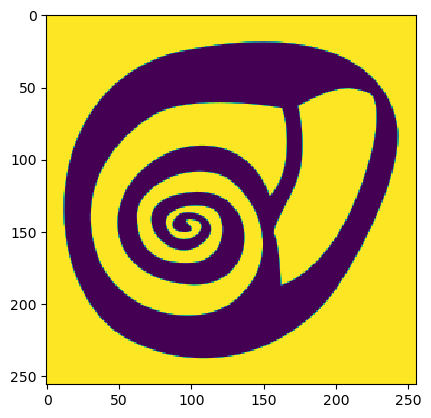

In [2]:
img = np.array(Image.open("test_img/image01.png")) / 255.0
img = img[:, :, 2]
img = (img - np.amin(img)) / (np.amax(img)-np.amin(img))

plt.figure()
plt.imshow(img)
plt.show()

Extract contour

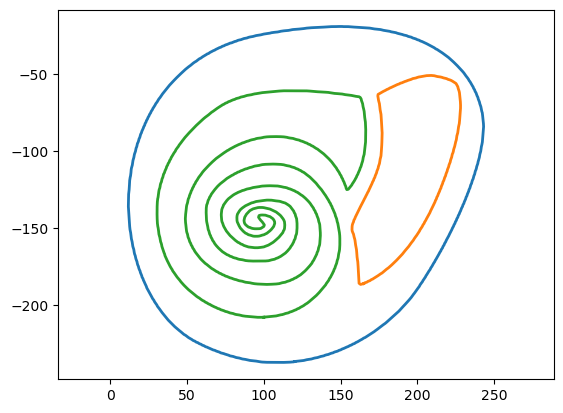

In [3]:
from skimage import measure

contours = []

plt.figure()
for contour in measure.find_contours(img, 0.5):
    contour = np.flip(contour)
    contour[:, 1] *= -1
    contours.append(contour)
    plt.plot(contour[:, 0], contour[:, 1], linewidth=2)
plt.axis('equal')
plt.show()

Segment fitting test

0.025652507053850915
0.010045592083649968
0.007165173061862928
0.0024288486495390726
0.002116149576297799
0.0010932965961527596
0.000928521480220601


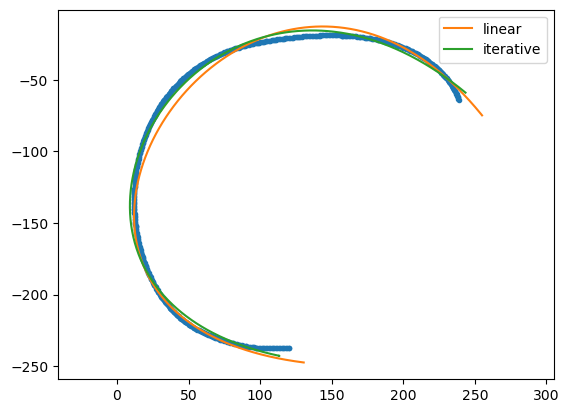

In [4]:
seg = contours[0][0:2*len(contours[0])//3, :]
plt.figure()
plt.plot(seg[:, 0], seg[:, 1], '.')


def closest_point(c, p):
    """closest point on curve"""
    # e^T c c^T e' - p c^T e' = 0
    ccT = c @ c.T
    pcT = p @ c.T
    a0 = ccT[0][1] - pcT[1]
    a1 = 2*ccT[0][2] + ccT[1][1] - 2*pcT[2]
    a2 = 3*ccT[0][3] + 2*ccT[1][2] + ccT[2][1] - 3*pcT[3]
    a3 = 3*ccT[1][3] + 2*ccT[2][2] + ccT[3][1]
    a4 = 3*ccT[2][3] + 2*ccT[3][2]
    a5 = 3*ccT[3][3]
    roots = np.roots([a5, a4, a3, a2, a1, a0])
    et0 = [1, 0, 0, 0]
    et1 = [1, 1, 1, 1]
    errs = [
        (0.0, np.linalg.norm(et0 @ c - p)),
        (1.0, np.linalg.norm(et1 @ c - p))
    ]
    for t in roots:
        if abs(t.imag) > 1e-6:
            continue
        t = t.real
        if not 0 < t < 1:
            continue
        et = [t**0, t**1, t**2, t**3]
        err = np.linalg.norm(et @ c - p)
        errs.append((t, err))
    return errs[np.argmin(np.array(errs)[:, 1])]


# linear least squares
ts = np.linspace(0, 1, len(seg))
eT = np.array([ts**0, ts**1, ts**2, ts**3])
c1 = np.linalg.solve(eT@eT.T, eT@seg)
p1 = eT.T @ c1
plt.plot(p1[:, 0], p1[:, 1], '-', label='linear')

# test closest point function
if False:
    plt.plot([0], [0], 'o')
    t, d = closest_point(c1, [0, 0])
    p = [t**0, t**1, t**2, t**3] @ c1
    plt.plot([p[0]], [p[1]], 'o')

# iterative linear fit
c2 = np.array(c1)
p2 = np.array(p1)
dts = 0.0 * ts
for iter in range(10):
    for i in range(len(ts)):
        t, d = closest_point(c2, seg[i])
        dts[i] = t - ts[i]
        ts[i] += 1.5*dts[i]
    ts = (ts-ts[0]) / (ts[-1]-ts[0])
    eT = np.array([ts**0, ts**1, ts**2, ts**3])
    c2 = np.linalg.solve(eT@eT.T, eT@seg)
    p2 = eT.T @ c2
    maxdt = np.amax(abs(dts))
    print(maxdt)
    if maxdt < 1e-3:
        break
plt.plot(p2[:, 0], p2[:, 1], '-', label='iterative')


plt.legend()
plt.axis('equal')
plt.show()

Spline fitting test

1.632724598995992 secs
36 pieces


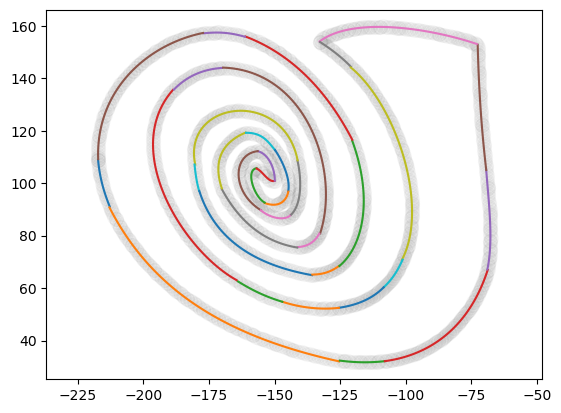

In [5]:
THRESHOLD = 0.1

def fit_bezier(seg, ts=None):

    # linear least squares
    if ts is None:
        ts = np.linspace(0, 1, len(seg))
    eT = np.array([ts**0, ts**1, ts**2, ts**3])
    c1 = np.linalg.solve(eT@eT.T, eT@seg)
    p1 = eT.T @ c1

    # iterative linear fit
    c2 = np.array(c1)
    dts = 0.0 * ts
    errs = 0.0 * ts
    for iter in range(3):
        for i in range(len(ts)):
            t, d = closest_point(c2, seg[i])
            assert 0.0 <= t <= 1.0
            dts[i] = t - ts[i]
            ts[i] += 1.5*dts[i]
            errs[i] = d
        ts = (ts-ts[0]) / (ts[-1]-ts[0])
        # ts = np.maximum(0.0, np.minimum(1.0, ts))
        eT = np.array([ts**0, ts**1, ts**2, ts**3])
        c2 = np.linalg.solve(eT@eT.T, eT@seg)
        maxdt = np.amax(abs(dts))
        maxerr = np.amax(errs)
        # print(maxdt)
        if maxdt < 1e-3:
            break
        if iter >= 2 and maxerr > 1.5 * THRESHOLD:
            break
        if maxerr < 0.5 * THRESHOLD:
            break

    return c2, ts, errs


def fit_spline(seg, ts=None):
    # print(seg.shape)
    c, ts, errs = fit_bezier(seg, ts)
    w = np.linspace(0, 1, len(errs))
    # w = (4.0*w*(1.0-w)) ** 0.5
    # maxi = np.argmax(errs*w)
    maxi = np.argmax(errs)

    # cut at minimum error
    # prevent cutting near end
    errss = gaussian_filter1d(errs, 0.025*len(errs), mode='reflect')
    mins = argrelextrema(errss, np.less)[0]
    # if errss[0] < errss[1]:
    #     mins = np.concatenate(([0], mins))
    # if errss[-1] < errss[-2]:
    #     mins = np.concatenate((mins, [len(errss)-1]))
    mins = [_ for _ in mins if 4 <= _ < len(seg)-4]
    maxi = len(seg) // 2
    if len(mins) >= 2:
        maxi = np.argmax(errs[mins[0]:mins[-1]])+mins[0]
    maxe = errs[maxi]

    if False:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
        ax1.plot(ts, errs)
        ax1.plot(ts, errss)
        ax1.plot(ts[mins], errs[mins], 'o')
        ax2.plot(seg[:, 0], seg[:, 1])
        ps = np.array([ts**0, ts**1, ts**2, ts**3]).T @ c
        ax2.plot(ps[:, 0], ps[:, 1])
        ax2.plot(ps[(mins[0], mins[-1]), 0], ps[(mins[0], mins[-1]), 1], 'o')
        ax2.axis('equal')
        plt.show()

    if maxi < 4 or maxi >= len(seg)-4:
        maxi = len(seg) // 2

    if np.mean(errs) < THRESHOLD or len(seg) < 8:
        return [(c, seg)]

    # ts1 = ts[:maxi+1] / ts[maxi]
    # ts2 = (ts[maxi:]-ts[maxi]) / (1.0-ts[maxi])
    ts1 = ts2 = None
    sp1 = fit_spline(seg[:maxi+1], ts1)
    sp2 = fit_spline(seg[maxi:], ts2)
    return sp1+sp2


# seg = contours[1][0:4*len(contours[1])//5, :]
# seg = contours[1][0:7*len(contours[1])//8, :]
# seg = contours[1]*1.0
seg = contours[2]*1.0
seg = np.flip(seg)
seg[:, 1] += 10.0 * np.sin(seg[:, 0]/40.0)
seg[:, 0] += 10.0 * np.cos(seg[:, 1]/40.0)
seg = np.concatenate((seg, seg[0:1]))

t0 = perf_counter()
spline = fit_spline(seg)
t1 = perf_counter()
print(t1-t0, "secs")
print(len(spline), 'pieces')

plt.figure()
plt.plot(seg[:, 0], seg[:, 1], 'k.', markersize=20, alpha=0.02)

for c, seg1 in spline:
    ts = np.linspace(0, 1)
    eT = np.array([ts**0, ts**1, ts**2, ts**3])
    p = eT.T @ c
    plt.plot(p[:, 0], p[:, 1])

plt.axis('equal')
plt.show()

Optimize split location

Least squares fitting $l=(Ax-b)^T(Ax-b)=x^TA^TAx-2x^TA^Tb-2(A^Tb)^Tx+b^Tb$

Bezier curve fitting: $x=c$, $A=e_T(t)$, $b=p$

$L=f(A^TA,A^Tb)=f\left(\sum_i e_T(t_i)^Te_T(t_i), \sum_i e_T(t_i)^Tp_i\right)$

Let $x_i=[p_i, t_i]$, $L=f\left(\sum_i g(x_i)\right) \approx f\left(\int c(j)dj\right)$

Split spline into $n$ pieces, endpoints $s_0$, $s_1$... $s_n$ with fixed $s_0,s_n$

Minimize for $\{s_1...s_{n-1}\}$: $L=\sum_{i=0}^{n-1}f\left(\int_{s_i}^{s_{i+1}}c(s)ds\right)$

0.168201210006373 secs
4 pieces
Desired error not necessarily achieved due to precision loss.
37.2164811447562
0.01876422700297553 secs


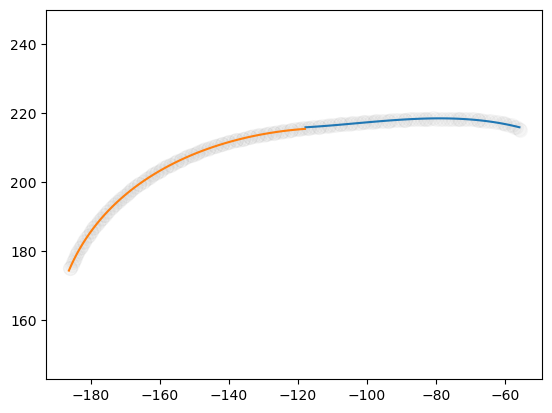

In [177]:
def os_get_ds(seg):
    ds = np.zeros(len(seg))
    for i in range(len(seg)):
        i0 = max(i-1, 0)
        i1 = min(i+1, len(seg)-1)
        # ds[i] = np.linalg.norm((seg[i1]-seg[i0])/(i1-i0))
        ds[i] = np.linalg.norm((seg[i1]-seg[i0])/2)
    s = np.concatenate(([0.0], np.cumsum(ds)))
    return ds, s

def os_eval_f_int(p_, ds_, s, s1, s2):
    assert len(s) == len(ds_)+1
    i = np.where((s1<=s) & (s<=s2))[0]
    if len(i) <= 2:
        return None, 0.0
    i0 = max(min(i)-1, 0)
    i1 = min(max(i)+1, len(s)-1)
    if i1-i0 <= 2:
        return None, 0.0
    ts = (s[i0:i1]-s1)/(s2-s1)
    eT = np.array([ts**0, ts**1, ts**2, ts**3]).T
    ds = np.array(ds_[i0:i1][:,None])
    ds[0] *= (s[i0+1]-s1)/(s[i0+1]-s[i0])
    ds[-1] *= (s2-s[i1-1])/(s[i1]-s[i1-1])
    p = p_[i0:i1]
    A = (ds*eT).T @ eT
    b = (ds*eT).T @ p
    try:
        c = np.linalg.solve(A, b)
    except np.linalg.LinAlgError:
        return None, 0
    p1 = eT @ c
    err = np.sum((p1-p)**2*ds)
    return c, err


seg = contours[1][0:4*len(contours[1])//5, :]
seg = np.flip(seg)
seg = np.array(seg)
seg[:, 1] += 10.0 * np.sin(seg[:, 0]/40.0)
# seg[:, 0] += 10.0 * np.cos(seg[:, 1]/40.0)
# seg = np.concatenate((seg, seg[0:1]))

t0 = perf_counter()
spline = fit_spline(seg)
t1 = perf_counter()
print(t1-t0, "secs")
print(len(spline), 'pieces')

seg = seg[-(len(spline[-2][1])+len(spline[-1][1])):]
spline = spline[-2:]

seg_ds, seg_s = os_get_ds(seg)
c0, err = os_eval_f_int(seg, seg_ds, seg_s, seg_s[0], seg_s[-1])


def smap(t):
    s0, s1 = seg_s[0], seg_s[-1]
    return s0 + (s1-s0) * (1.0/(1.0+np.exp(-t)))

def inv_smap(s):
    s0, s1 = seg_s[0], seg_s[-1]
    s = (s-s0) / (s1-s0)
    return np.clip(np.log(s/(1.0-s)), -10, 10)

def fit_cost(t):
    s = smap(t)
    c0, err0 = os_eval_f_int(seg, seg_ds, seg_s, seg_s[0], s)
    c1, err1 = os_eval_f_int(seg, seg_ds, seg_s, s, seg_s[-1])
    return err0 + err1

def fit_param(t):
    s = smap(t)
    c0, err0 = os_eval_f_int(seg, seg_ds, seg_s, seg_s[0], s)
    c1, err1 = os_eval_f_int(seg, seg_ds, seg_s, s, seg_s[-1])
    return c0, c1

# t = np.linspace(-10, 10, 100)
# e = np.array([fit_cost(ti) for ti in t])
# plt.plot(t, e/seg_s[-1], '.')

t0 = inv_smap(seg_s[len(spline[0][1])])
# print(t0)

optres = scipy.optimize.minimize(fit_cost, t0)
print(optres.message)
c0, c1 = fit_param(optres.x[0])

print(os_eval_f_int(seg, seg_ds, seg_s, seg_s[0], seg_s[-1])[1])


t2 = perf_counter()
print(t2-t1, "secs")

plt.figure()
plt.plot(seg[:, 0], seg[:, 1], 'k.', markersize=20, alpha=0.02)

def plot_c(c):
    ts = np.linspace(0, 1)
    eT = np.array([ts**0, ts**1, ts**2, ts**3])
    p = eT.T @ c
    plt.plot(p[:, 0], p[:, 1])

# plot_c(spline[0][0])
# plot_c(spline[1][0])

plot_c(c0)
plot_c(c1)

plt.axis('equal')
plt.show()

1.555145619000541 secs
35 pieces
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 32.081239085340854
             x: [ 1.823e-02  8.662e-02 ...  9.369e-01  9.709e-01]
           nit: 3339
          nfev: 4267
 final_simplex: (array([[ 1.823e-02,  8.662e-02, ...,  9.369e-01,
                         9.709e-01],
                       [ 1.823e-02,  8.662e-02, ...,  9.369e-01,
                         9.709e-01],
                       ...,
                       [ 1.823e-02,  8.662e-02, ...,  9.369e-01,
                         9.709e-01],
                       [ 1.823e-02,  8.662e-02, ...,  9.369e-01,
                         9.709e-01]]), array([ 3.208e+01,  3.208e+01, ...,  3.208e+01,  3.208e+01]))
4.20085648400709 secs


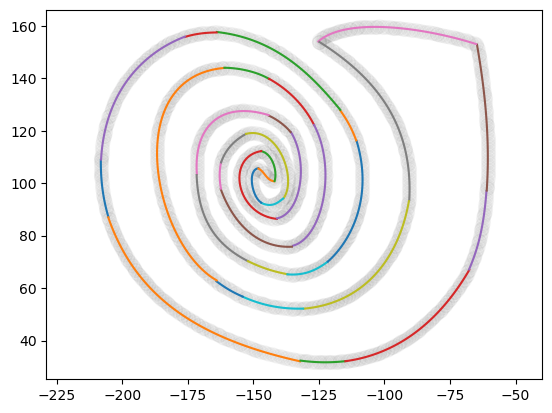

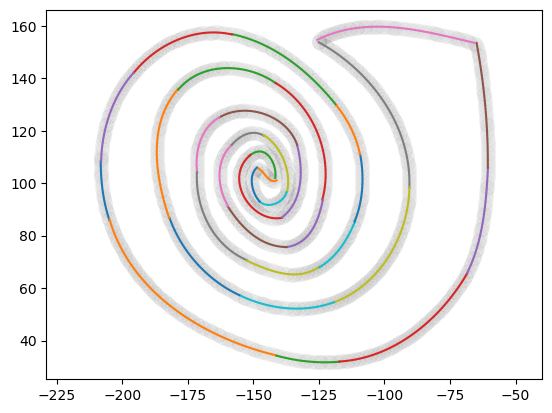

In [262]:
seg = contours[1][0:4*len(contours[1])//5, :]
seg = contours[1][0:7*len(contours[1])//8, :]
seg = contours[2]*1.0
seg = np.flip(seg)
seg = np.array(seg)
seg[:, 1] += 10.0 * np.sin(seg[:, 0]/40.0)
# seg[:, 0] += 10.0 * np.cos(seg[:, 1]/40.0)
# seg = np.concatenate((seg, seg[0:1]))

t0 = perf_counter()
spline = fit_spline(seg)
t1 = perf_counter()
print(t1-t0, "secs")
print(len(spline), 'pieces')

seg_ds, seg_s = os_get_ds(seg)
c0, err = os_eval_f_int(seg, seg_ds, seg_s, seg_s[0], seg_s[-1])

def smap(t):
    s0, s1 = seg_s[0], seg_s[-1]
    return s0+(s1-s0)*t
    t = np.exp(np.concatenate((t, [0.0])))
    t = np.cumsum(t/np.sum(t))
    return s0 + (s1-s0) * t[:-1]

def inv_smap(s):
    s0, s1 = seg_s[0], seg_s[-1]
    return (s-s0)/(s1-s0)
    t = np.concatenate(([0.0], (s-s0)/(s1-s0)))
    t = np.log(np.fmax(np.diff(t), 1e-6))
    optres = scipy.optimize.minimize(
        lambda c: np.mean((smap(t+c)-s)**2),
        [np.log(np.sum(np.exp(t))+1.0)]
    )
    return t + optres.x[0]

def fit_cost(t):
    s = np.concatenate(([seg_s[0]], smap(t), [seg_s[-1]]))
    toterr = 0.0
    for s0, s1 in zip(s[:-1], s[1:]):
        c, err = os_eval_f_int(seg, seg_ds, seg_s, s0, s1)
        toterr += err
    return toterr

def fit_param(t):
    s = np.concatenate(([seg_s[0]], smap(t), [seg_s[-1]]))
    params = []
    for s0, s1 in zip(s[:-1], s[1:]):
        c, err = os_eval_f_int(seg, seg_ds, seg_s, s0, s1)
        params.append(c)
    return params

i = 1+np.cumsum([len(s[1])-1 for s in spline[:-1]])
# print(seg_s[i])
t0 = inv_smap(seg_s[i])
# print(smap(t0))

# method = "BFGS"
method = "Nelder-Mead"
# method = "Powell"
optres = scipy.optimize.minimize(fit_cost, t0, method=method)
print(optres)
cs = fit_param(optres.x)

t2 = perf_counter()
print(t2-t1, "secs")

def plot_c(c):
    ts = np.linspace(0, 1)
    eT = np.array([ts**0, ts**1, ts**2, ts**3])
    p = eT.T @ c
    plt.plot(p[:, 0], p[:, 1])

plt.figure()
plt.plot(seg[:, 0], seg[:, 1], 'k.', markersize=20, alpha=0.02)
for c, seg1 in spline:
    plot_c(c)
plt.axis('equal')
plt.show()

plt.figure()
plt.plot(seg[:, 0], seg[:, 1], 'k.', markersize=20, alpha=0.02)
for c in cs:
    plot_c(c)
plt.axis('equal')
plt.show()
